In [ ]:
import os

In [ ]:
with open('/medical-data/zsxm/e3v/resized_data/labels.txt', 'r') as f:
    lines = f.readlines()

label_dict = {}
for line in lines:
    video, label = line.split()
    video = os.path.basename(video).lower()
    label_dict[video] = label

In [ ]:
root = '/medical-data/zsxm/e3v/resized_data/'

for cate in ['train', 'val', 'test']:
    with open(os.path.join(root, f'{cate}_labels.txt'), 'w') as lf:
        for video in sorted(os.listdir(os.path.join(root, cate))):
            label = label_dict[video.lower()]
            lf.write(f'{os.path.join(root, cate, video)}\t{label}\n')

In [ ]:
from mmcv import load

annotation = load('/medical-data/zsxm/e3v/resized_data/val_annotations_error.pkl')

In [ ]:
print(annotation[0].keys())

In [ ]:
import os
file_dir = set()
for v in os.listdir('/medical-data/zsxm/e3v/resized_data/val/'):
    file_dir.add(os.path.splitext(v.lower())[0])

anno_dir = set()
for it in annotation:
    anno_dir.add(it['frame_dir'].lower())

print(file_dir == anno_dir)

In [ ]:
annotation[0]['keypoint'].shape

In [ ]:
import numpy as np

keypoint = annotation[1]['keypoint']
print(annotation[1]['frame_dir'])

In [ ]:
offset = np.linalg.norm(np.diff(keypoint.astype(np.double), axis=2), ord=2, axis=3).sum(axis=-1).mean(axis=-1)
print(offset)

In [ ]:
from pyskl.utils.visualize import Vis3DPose, Vis2DPose
from mmcv import load

annotation = load('examples/lwf_anno.pkl')
anno = annotation[0]
vid = Vis2DPose(anno, thre=0.2, out_shape=(480, 856), layout='coco', fps=15, video=None)
vid.ipython_display(fps=15)

In [ ]:
import copy
import numpy as np

anno2 = copy.deepcopy(anno)

offset = np.linalg.norm(np.diff(anno2['keypoint'].astype(np.double), axis=1), ord=2, axis=3).sum(axis=-1).mean(axis=-1)

# kp = anno2['keypoint'].astype(np.double)
# gravitycenter = kp.mean(axis=2, keepdims=True)
# offset = np.linalg.norm(np.diff(kp-gravitycenter, axis=1), ord=2, axis=3).sum(axis=-1).mean(axis=-1)

idx = np.argmax(offset)
print(offset, idx)
anno2['num_person_raw'] = 1
anno2['keypoint'] = anno2['keypoint'][idx:idx+1]
anno2['keypoint_score'] = anno2['keypoint_score'][idx:idx+1]
vid = Vis2DPose(anno2, thre=0.2, out_shape=(480, 856), layout='coco', fps=15, video=None)
vid.ipython_display()

In [ ]:
from mmcv import load, dump
import numpy as np

input_dir = '/medical-data/zsxm/e3v/resized_data/val_annotations_error.pkl'
output_dir = '/medical-data/zsxm/e3v/resized_data/val_annotations_error_one.pkl'

annotation = load(input_dir)
for anno in annotation:
    offset = np.linalg.norm(np.diff(anno['keypoint'].astype(np.double), axis=1), ord=2, axis=3).sum(axis=-1).mean(axis=-1)
    idx = np.argmax(offset)
    print(anno['frame_dir'], anno['num_person_raw'], offset, idx)
    anno['keypoint'] = anno['keypoint'][idx:idx+1]
    anno['keypoint_score'] = anno['keypoint_score'][idx:idx+1]
    anno['num_person_raw'] = 1

dump(annotation, output_dir)


In [ ]:
from mmcv import load, dump
import numpy as np

input_dir = '/medical-data/zsxm/e3v/resized_data/val_annotations_error.pkl'
output_dir = '/medical-data/zsxm/e3v/resized_data/val_annotations_error_two.pkl'

annotation = load(input_dir)
for anno in annotation:
    kp = anno['keypoint'].astype(np.double)
    gravitycenter = kp.mean(axis=2, keepdims=True)
    offset = np.linalg.norm(np.diff(kp-gravitycenter, axis=1), ord=2, axis=3).sum(axis=-1).mean(axis=-1)
    idx = np.argmax(offset)
    print(anno['frame_dir'], anno['num_person_raw'], offset, idx)
    anno['keypoint'] = anno['keypoint'][idx:idx+1]
    anno['keypoint_score'] = anno['keypoint_score'][idx:idx+1]
    anno['num_person_raw'] = 1

dump(annotation, output_dir)

In [ ]:
from mmcv import load, dump
import os.path as osp

root = '/medical-data/zsxm/e3v/resized_data/'

cates = [
    ('train', 'train_annotations_track.pkl'),
    ('valid', 'val_annotations_track.pkl'),
    ('test', 'test_annotations_track.pkl'),
]

annotations = []
split = {}
for c, cf in cates:
    annos = load(osp.join(root, cf))
    annotations.extend(annos)
    split[c] = [x['frame_dir'] for x in annos]

dump(dict(split=split, annotations=annotations), osp.join(root, 'annotations_track.pkl'))

In [ ]:
from mmcv import load, dump
import os.path as osp
root = '/medical-data/zsxm/e3v/resized_data/'
dataset = load(osp.join(root, 'annotations_track.pkl'))

In [ ]:
dataset['split']['train'] = dataset['split']['train'][:100]
dataset['split']['valid'] = dataset['split']['valid'][:100]
dataset['split']['test'] = dataset['split']['test'][:100]

In [ ]:
dump(dataset, osp.join(root, 'annotations_demo.pkl'))

In [ ]:
from mmcv import load, dump
import os.path as osp
root = '/medical-data/zsxm/e3v/resized_data/'
dataset = load(osp.join(root, 'annotations_track.pkl'))
print(len(dataset['annotations']))
print(dataset['annotations'][0].keys())
print(dataset['annotations'][0]['total_frames'])
print(dataset['annotations'][0]['keypoint'].shape)
print(dataset['annotations'][0]['label'])

In [ ]:
from tqdm import tqdm
for i in tqdm(range(len(dataset['annotations']))):
    kp = dataset['annotations'][i]['keypoint']
    kp_res = kp[:,1:] - kp[:,:-1]
    dataset['annotations'][i]['keypoint'] = kp_res
    dataset['annotations'][i]['total_frames'] = dataset['annotations'][i]['total_frames'] - 1
    dataset['annotations'][i]['keypoint_score'] = dataset['annotations'][i]['keypoint_score'][:,1:]

In [ ]:
dump(dataset, osp.join(root, 'annotations_residual.pkl'))

In [ ]:
from mmcv import load, dump
import os.path as osp
from tqdm import tqdm

root = '/medical-data/zsxm/e3v/resized_data/'
dataset = load(osp.join(root, 'annotations_residual.pkl'))

for i in tqdm(range(len(dataset['annotations']))):
    print(dataset['annotations'][i]['total_frames'],dataset['annotations'][i]['keypoint'].shape,dataset['annotations'][i]['keypoint_score'].shape)

In [4]:
from mmcv import load, dump
import os.path as osp
from tqdm import tqdm

root = '/medical-data/zsxm/e3v/resized_data/'
dataset = load(osp.join(root, 'ntu60_hrnet.pkl'))

print(len(dataset['annotations']))
print(dataset['annotations'][0].keys())
print(dataset['annotations'][0]['total_frames'])
print(dataset['annotations'][0]['keypoint'].shape)
print(dataset['annotations'][0]['label'])

for i in tqdm(range(len(dataset['annotations']))):
    if dataset['annotations'][0]['keypoint'].shape[0] > 1:
        print(dataset['annotations'][0]['keypoint'].shape, dataset['annotations'][0]['label'])

56578
dict_keys(['frame_dir', 'label', 'img_shape', 'original_shape', 'total_frames', 'keypoint', 'keypoint_score'])
103
(1, 103, 17, 2)
0


100%|██████████| 56578/56578 [00:00<00:00, 2944673.30it/s]


In [10]:
import torch
import json
loss = []
for line in open('work_dirs/e3v/stgcn++/bm/20230515_084932.log.json', 'r', encoding='utf-8'):
    js = json.loads(line)
    if 'mode' in js and js['mode'] == 'train' and js['epoch'] == 50:
        loss.append(js['loss'])
print(torch.tensor(loss).mean())

tensor(0.0360)


# 测试坐标数据有没有问题

In [1]:
from mmcv import load
import cv2
import numpy as np
from PIL import Image

In [2]:
data = load('/medical-data/zsxm/运动热量估计/eev_resized/clips/eem_delay.pkl')

In [20]:
print(data['annotations'][0]['img_shape'])
print(data['annotations'][0]['frame_dir'])

(480, 856)
hqh_elliptical_m_back_0000-0010


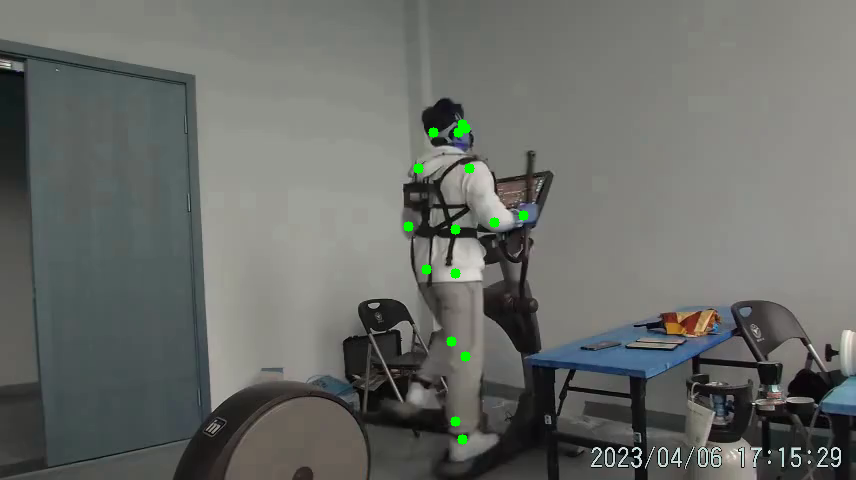

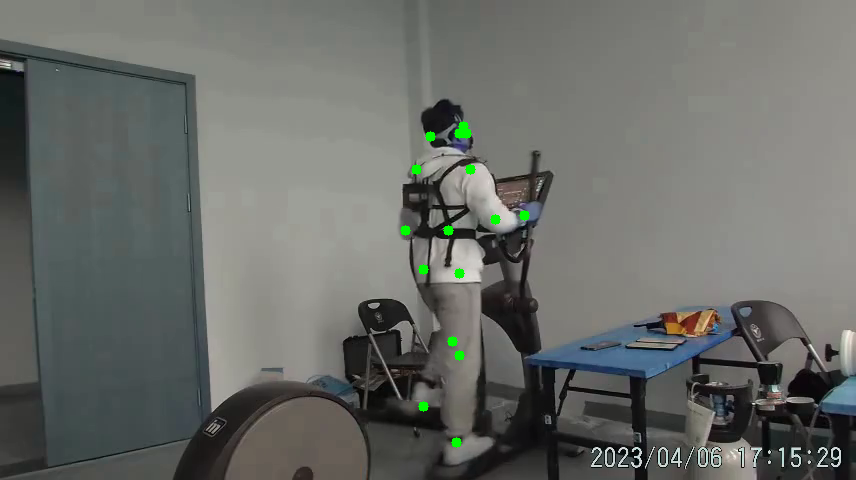

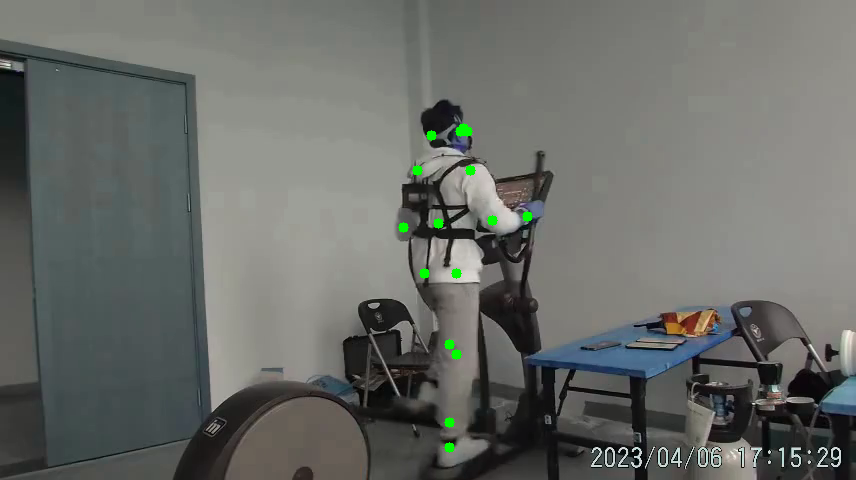

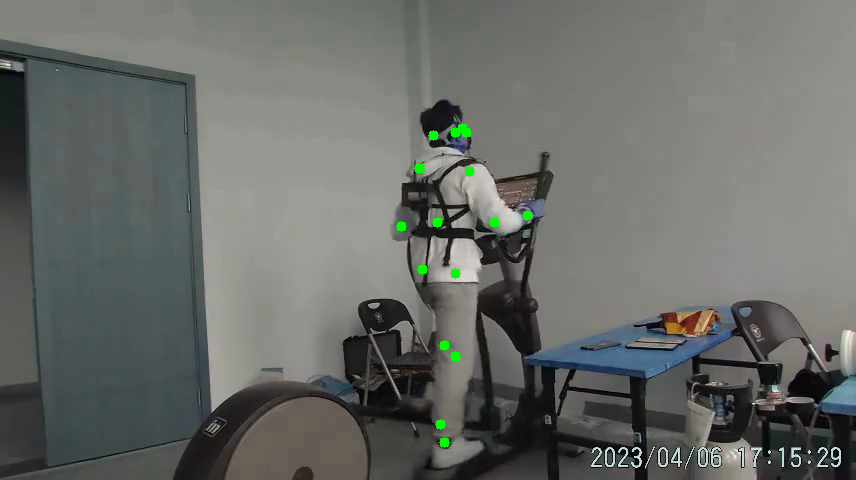

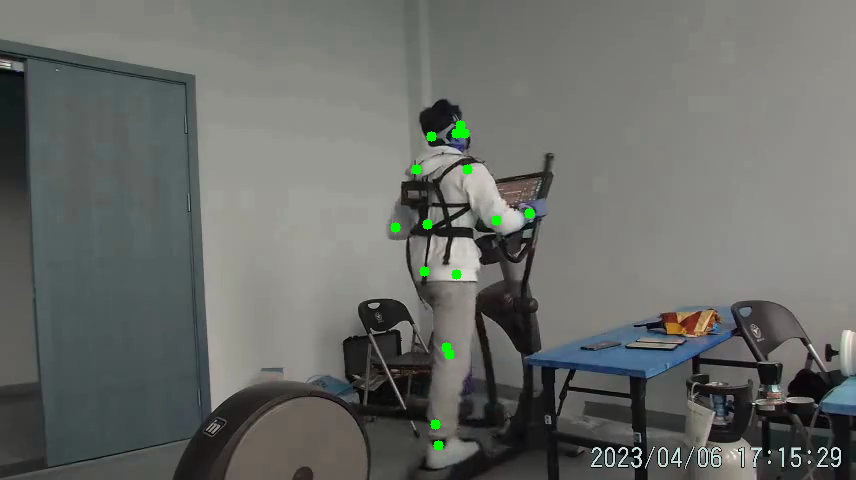

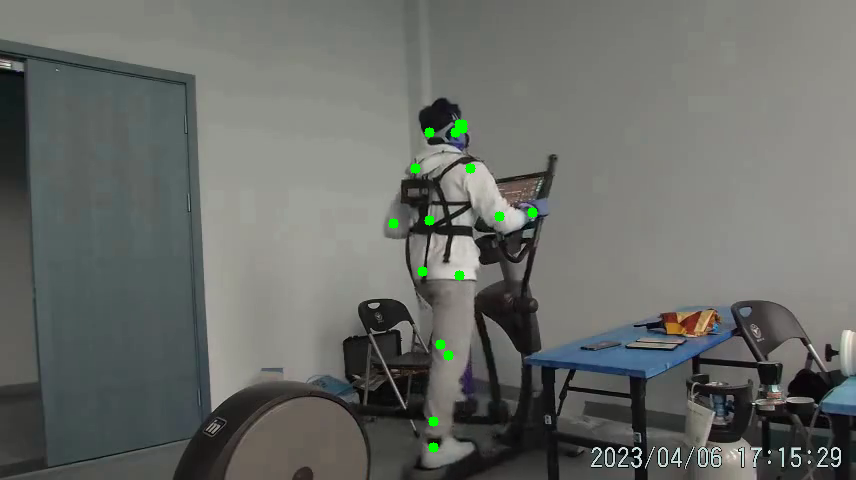

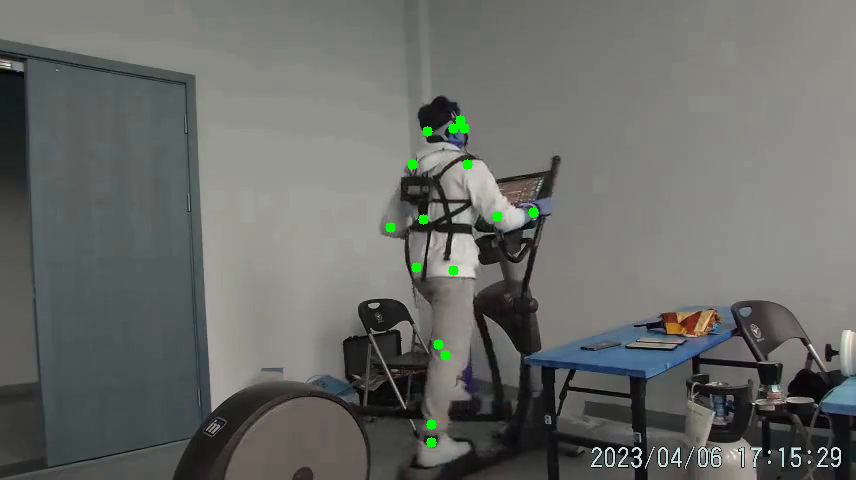

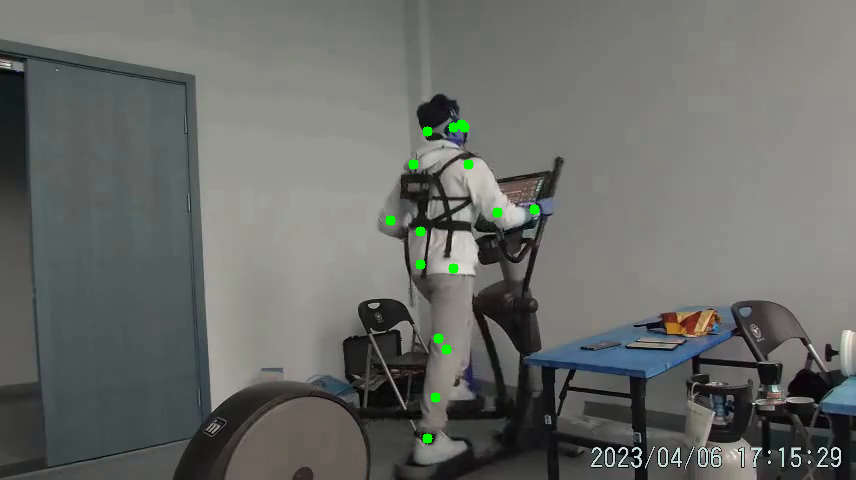

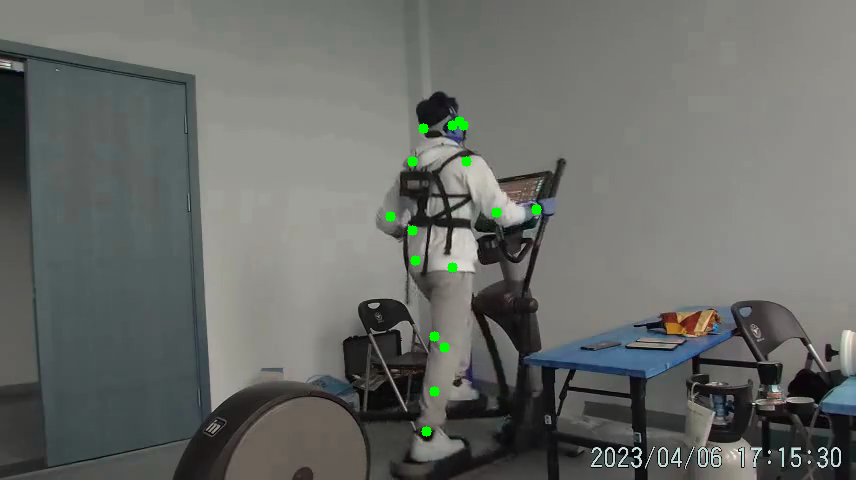

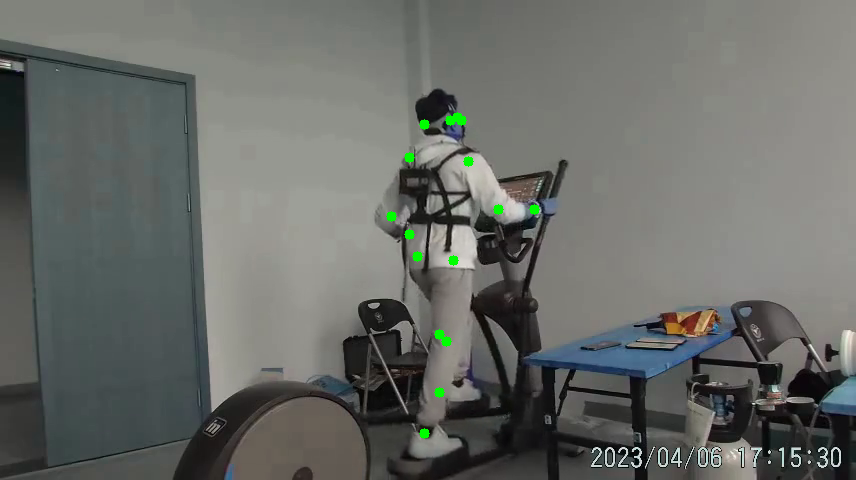

In [21]:
kp = data['annotations'][0]['keypoint']
cap = cv2.VideoCapture('/medical-data/zsxm/运动热量估计/eev_resized/clips/混合室法/hqh_elliptical_m_back_0000-0010.mp4')
for i in range(10):
    #canvas = np.zeros((480,856,3), dtype=np.uint8)
    _, canvas = cap.read()
    for k in kp[0,i]:
        cv2.circle(canvas, k.astype(int).tolist(), 5, (0, 255, 0), -1)
    display(Image.fromarray(canvas))
cap.release()